In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t

from datetime import datetime
import re
import seaborn as sns
%matplotlib inline

<h2> 1. What Factors Affect the Price of an Airbnb Listing in Seattle? </h2>

<h3> Loading and exploring the Seattle Airbnb Data </h3>

In this first section, we are going to load and explore the Seattle Airbnb Data set. The aim is to identify the most important features which we can use to answer the business questions given above.

In [40]:
df_seattle_listings_full = pd.read_csv('./seattle_airbnb_data/listings.csv')
df_seattle_calendar = pd.read_csv('./seattle_airbnb_data/calendar.csv')
#df_seattle_reviews = pd.read_csv('./seattle_airbnb_data/reviews.csv')

In [41]:
# print(df_seattle_calendar.head())
# print(df_seattle_calendar.info())

print(df_seattle_listings_full.head())
print(df_seattle_listings_full.info())

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

<h3> Split data into target and training features </h3>

In [42]:
df_seattle_listings = df_seattle_listings_full.drop(columns=['price','weekly_price','monthly_price'])

df_seattle_listings_target = df_seattle_listings_full[['price']]

<h3> Drop irrelevant features and transform str into numerical features </h3>

The first step will be to clean and transform features in the df_seattle_listings data frame, to make them usable in predictive modelling. In a first step, we are going to remove all columns, which likely have limited impact on a models predictive power.

In [43]:
df_seattle_listings_red = df_seattle_listings.drop([
                        'listing_url',
                        'scrape_id',
                        'last_scraped',
                        'name',
                        'experiences_offered',
                        'host_id',
                        'host_name',
                        'market',
                        'city',
                        'state',
                        'smart_location',
                        'country_code',
                        'country',
                        'requires_license',
                        'license',
                        'jurisdiction_names',
                        'thumbnail_url',
                        'medium_url',
                        'picture_url',
                        'xl_picture_url',
                        'host_id',
                        'host_url',
                        'host_name',
                        'host_thumbnail_url',
                        'host_picture_url',
                        'calendar_last_scraped',
                        'first_review',
                        'last_review',
                        'calendar_updated', # might be relevant - maybe include
                        'has_availability'
                        ], axis=1)

Next, we are going to transform all features into a usable format. This means that all numerical data will be transformed to numerical data, if it currently has dtype=object for example.

Feature: 'host_since'

In [44]:
# Convert 'host_since' to datetime
df_seattle_listings_red['host_since'] = pd.to_datetime(df_seattle_listings_red['host_since'])

# Calculate the difference in days between 'host_since' and today
today = pd.to_datetime(datetime.today().date())
df_seattle_listings_red['host_since'] = (today - df_seattle_listings_red['host_since']).dt.days

Feature: 'host_response_time'

In [45]:
response_time_mapping = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

df_seattle_listings_red['host_response_time'] = df_seattle_listings_red['host_response_time'].map(response_time_mapping)

df_seattle_listings_red['host_response_time'] = df_seattle_listings_red['host_response_time'].fillna(-1).astype('int64')

Feature: 'host_response_rate'

In [46]:
df_seattle_listings_red['host_response_rate'] = df_seattle_listings_red['host_response_rate'].str.replace('%', '')
df_seattle_listings_red['host_response_rate'] = pd.to_numeric(df_seattle_listings_red['host_response_rate'], errors='coerce')

# Handle NaN values by replacing them with -1
df_seattle_listings_red['host_response_rate'] = df_seattle_listings_red['host_response_rate'].fillna(-1).astype('int64')

Feature: 'host_acceptance_rate'

In [47]:
df_seattle_listings_red['host_acceptance_rate'] = df_seattle_listings_red['host_acceptance_rate'].str.replace('%', '')
df_seattle_listings_red['host_acceptance_rate'] = pd.to_numeric(df_seattle_listings_red['host_acceptance_rate'], errors='coerce')

# Handle NaN values by replacing them with -1
df_seattle_listings_red['host_acceptance_rate'] = df_seattle_listings_red['host_acceptance_rate'].fillna(-1).astype('int64')

Feature: 'host_is_superhost'

In [48]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['host_is_superhost'] = df_seattle_listings_red['host_is_superhost'].map(response_time_mapping)

df_seattle_listings_red['host_is_superhost'] = df_seattle_listings_red['host_is_superhost'].fillna(-1).astype('int64')

Feature: 'host_has_profile_pic'

In [49]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['host_has_profile_pic'] = df_seattle_listings_red['host_has_profile_pic'].map(response_time_mapping)

df_seattle_listings_red['host_has_profile_pic'] = df_seattle_listings_red['host_has_profile_pic'].fillna(-1).astype('int64')

Feature: 'host_identity_verified'

In [50]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['host_identity_verified'] = df_seattle_listings_red['host_identity_verified'].map(response_time_mapping)

df_seattle_listings_red['host_identity_verified'] = df_seattle_listings_red['host_identity_verified'].fillna(-1).astype('int64')

Feature: 'bed_type'

In [51]:
response_time_mapping = {
    'Real Bed': 0,
    'Futon': 1,
    'Pull-out Sofa': 2,
    'Airbed': 3,
    'Couch': 4
}

df_seattle_listings_red['bed_type'] = df_seattle_listings_red['bed_type'].map(response_time_mapping)

df_seattle_listings_red['bed_type'] = df_seattle_listings_red['bed_type'].fillna(-1).astype('int64')

Feature: 'security_deposit'

In [52]:
df_seattle_listings_red['security_deposit'] = df_seattle_listings_red['security_deposit'].str.replace('$', '')
df_seattle_listings_red['security_deposit'] = pd.to_numeric(df_seattle_listings_red['security_deposit'], errors='coerce')

# Handle NaN values by replacing them with -1
df_seattle_listings_red['security_deposit'] = df_seattle_listings_red['security_deposit'].fillna(-1).astype('float')

Feature: 'cleaning_fee'

In [53]:
df_seattle_listings_red['cleaning_fee'] = df_seattle_listings_red['cleaning_fee'].str.replace('$', '')
df_seattle_listings_red['cleaning_fee'] = pd.to_numeric(df_seattle_listings_red['cleaning_fee'], errors='coerce')

# Handle NaN values by replacing them with -1
df_seattle_listings_red['cleaning_fee'] = df_seattle_listings_red['cleaning_fee'].fillna(-1).astype('float')

Feature: 'extra_people'

In [54]:
df_seattle_listings_red['extra_people'] = df_seattle_listings_red['extra_people'].str.replace('$', '')
df_seattle_listings_red['extra_people'] = pd.to_numeric(df_seattle_listings_red['extra_people'], errors='coerce')

# Handle NaN values by replacing them with -1
df_seattle_listings_red['extra_people'] = df_seattle_listings_red['extra_people'].fillna(-1).astype('float')

Feature: 'calendar_udpated'

In [55]:
# def convert_to_days(time_str):
#     match = re.match(r'(\d+)\s(\w+)\sago', time_str)
#     if not match:
#         return None
#     value, unit = match.groups()
#     value = int(value)
    
#     if unit == 'day' or unit == 'days':
#         return value
#     elif unit == 'week' or unit == 'weeks':
#         return value * 7
#     elif unit == 'month' or unit == 'months':
#         return value * 30
#     elif unit == 'year' or unit == 'years':
#         return value * 365
#     else:
#         return None

# df_seattle_listings_red['calendar_updated'] = df_seattle_listings_red['calendar_updated'].apply(convert_to_days)

# response_time_mapping = {
#     'yesterday': 1,
#     'today': 0,
#     'never': -1
# }

# df_seattle_listings_red['calendar_updated'] = df_seattle_listings_red['calendar_updated'].map(response_time_mapping)

Feature: 'instant_bookable'

In [56]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['instant_bookable'] = df_seattle_listings_red['instant_bookable'].map(response_time_mapping)

df_seattle_listings_red['instant_bookable'] = df_seattle_listings_red['instant_bookable'].fillna(-1).astype('int64')

Feature: 'cancellation_policy'

In [57]:
response_time_mapping = {
    'moderate': 0,
    'strict': 1,
    'flexible': 2
}

df_seattle_listings_red['cancellation_policy'] = df_seattle_listings_red['cancellation_policy'].map(response_time_mapping)

df_seattle_listings_red['cancellation_policy'] = df_seattle_listings_red['cancellation_policy'].fillna(-1).astype('int64')

Feature: 'require_guest_profile_picture'

In [58]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['require_guest_profile_picture'] = df_seattle_listings_red['require_guest_profile_picture'].map(response_time_mapping)

df_seattle_listings_red['require_guest_profile_picture'] = df_seattle_listings_red['require_guest_profile_picture'].fillna(-1).astype('int64')

Feature: 'require_guest_phone_verification'

In [59]:
response_time_mapping = {
    'f': 0,
    't': 1
}

df_seattle_listings_red['require_guest_phone_verification'] = df_seattle_listings_red['require_guest_phone_verification'].map(response_time_mapping)

df_seattle_listings_red['require_guest_phone_verification'] = df_seattle_listings_red['require_guest_phone_verification'].fillna(-1).astype('int64')

Feature: 'room_type'

In [60]:
response_time_mapping = {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2
}

df_seattle_listings_red['room_type'] = df_seattle_listings_red['room_type'].map(response_time_mapping)

df_seattle_listings_red['room_type'] = df_seattle_listings_red['room_type'].fillna(-1).astype('int64')

<h3> Separate numerical from textual data </h3>

In [61]:
df_seattle_listings_text = df_seattle_listings_red.select_dtypes(include='dtype')

df_seattle_listings_num = df_seattle_listings_red.select_dtypes(exclude='dtype')

<h3> Delete columns with too many nan-values and fill the rest with -1 - then standardize the features </h3>

In [62]:
threshold = 0.50 * len(df_seattle_listings_num)

df_seattle_listings_num = df_seattle_listings_num.dropna(thresh=len(df_seattle_listings_num) - threshold, axis=1)

In [64]:
df_seattle_listings_num = df_seattle_listings_num.fillna(-1)

1. fill in missing values (maybe > 75% nan values delete)
2. normalize/standardize data
3. reduce dimensionality via PCA

<h3> Reduce dimensionality of data set by using principle component analysis (PCA) </h3>

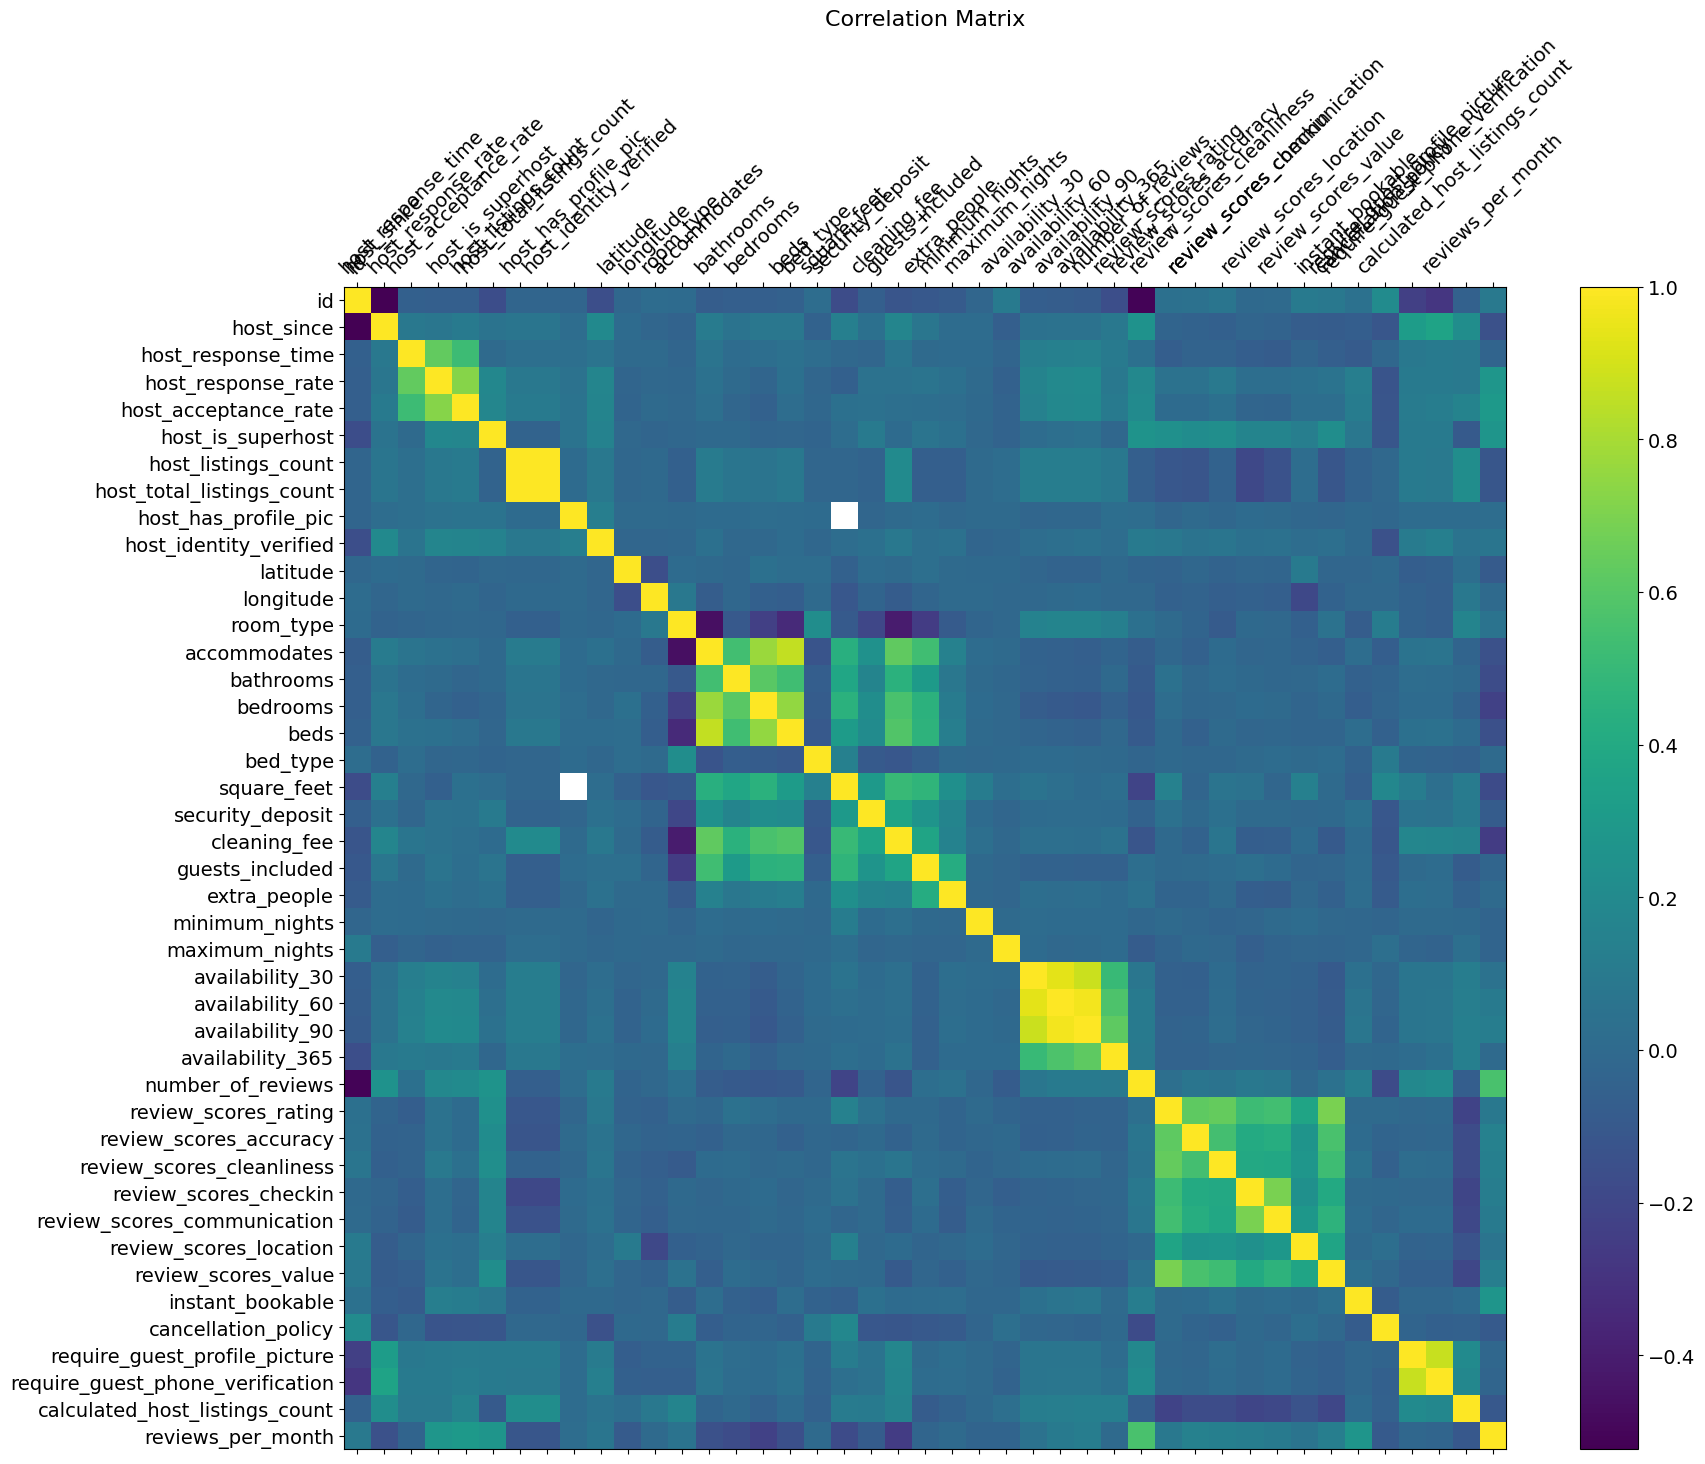

In [30]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_seattle_listings_num.corr(), fignum=f.number)
plt.xticks(range(df_seattle_listings_num.select_dtypes(['number']).shape[1]), df_seattle_listings_num.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_seattle_listings_num.select_dtypes(['number']).shape[1]), df_seattle_listings_num.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [25]:
df_seattle_listings_text.shape

(3818, 18)

In [26]:
df_seattle_listings_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   3818 non-null   object
dtypes: object(1)
memory usage: 30.0+ KB
